# Capstone Project — California Housing  
## Part 3: Baseline Modeling (Ridge & HGB)

**Objective:**  
Train and evaluate baseline regression models on the preprocessed California Housing data.  

This notebook continues from the preprocessing phase and focuses on:
- Loading the saved `preprocessor.pkl`
- Fitting a **Ridge Regression** (linear baseline)
- Fitting a **HistGradientBoostingRegressor** (nonlinear baseline)
- Evaluating performance on Train, Validation, and Test sets
- Comparing models by accuracy, interpretability, and speed

---

**Evaluation metrics:**  
- Mean Absolute Error (MAE)  
- Root Mean Squared Error (RMSE)  
- Coefficient of Determination (R²)

## Imports and setup

In [1]:
# --- 0. Imports & setup ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- reproducibility ---
SEED = 42
np.random.seed(SEED)
plt.rcParams["figure.dpi"] = 130
sns.set_theme(style="whitegrid", palette="deep")
pd.set_option("display.precision", 4)

# --- load dataset again (same as before) ---
data = fetch_california_housing(as_frame=True)
df = data.frame.copy()
df.rename(columns={"MedHouseVal": "target"}, inplace=True)

# --- split (same 60/20/20 logic to ensure consistency) ---
X = df.drop("target", axis=1)
y = df["target"]
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=SEED)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=SEED)

# --- load preprocessor ---
preprocessor = joblib.load("preprocessor.pkl")

X_train_prep = preprocessor.transform(X_train)
X_val_prep = preprocessor.transform(X_val)
X_test_prep = preprocessor.transform(X_test)

print("Data and preprocessor loaded. Shapes:", X_train_prep.shape, X_val_prep.shape, X_test_prep.shape)


Data and preprocessor loaded. Shapes: (12384, 8) (4128, 8) (4128, 8)


## Ridge Regression (with GridSearchCV and metrics)

In [2]:
# ---  Ridge Regression (GridSearchCV with log-spaced α) ---

# --- parameter grid (log-spaced alpha values) ---
ridge_param_grid = {"alpha": np.logspace(-3, 3, 7)}

ridge = Ridge(random_state=SEED)

# --- GridSearchCV setup ---
ridge_cv = GridSearchCV(
    ridge,
    ridge_param_grid,
    cv=5,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=0,
)

# --- timing ---
start = time.time()
ridge_cv.fit(X_train_prep, y_train)
fit_time = time.time() - start

print(f"Ridge best α: {ridge_cv.best_params_['alpha']:.3f}")
print(f"Fit time: {fit_time:.2f} s")

# --- best model ---
ridge_best = ridge_cv.best_estimator_

# --- predictions ---
def evaluate_model(model, X_tr, y_tr, X_val, y_val, X_te, y_te, name):
    """Compute MAE, RMSE, and R2 on train, val, and test."""
    metrics = []
    for split, (X, y) in zip(
        ["Train", "Val", "Test"], [(X_tr, y_tr), (X_val, y_val), (X_te, y_te)]
    ):
        y_pred = model.predict(X)
        mae = mean_absolute_error(y, y_pred)
        rmse = np.sqrt(mean_squared_error(y, y_pred))
        r2 = r2_score(y, y_pred)
        metrics.append((name, split, mae, rmse, r2))
    return metrics

ridge_metrics = evaluate_model(
    ridge_best, X_train_prep, y_train, X_val_prep, y_val, X_test_prep, y_test, "Ridge"
)

# --- collect results ---
ridge_results = pd.DataFrame(
    ridge_metrics, columns=["Model", "Split", "MAE", "RMSE", "R2"]
)
ridge_results["FitTime(s)"] = fit_time
ridge_results

Ridge best α: 100.000
Fit time: 2.02 s


,Model,Split,MAE,RMSE,R2,FitTime(s)
0,Ridge,Train,0.5257,0.7039,0.6266,2.0167
1,Ridge,Val,0.5336,0.7119,0.6117,2.0167
2,Ridge,Test,0.5270,0.7064,0.6361,2.0167


## Tree Ensemble Baseline (HistGradientBoostingRegressor)

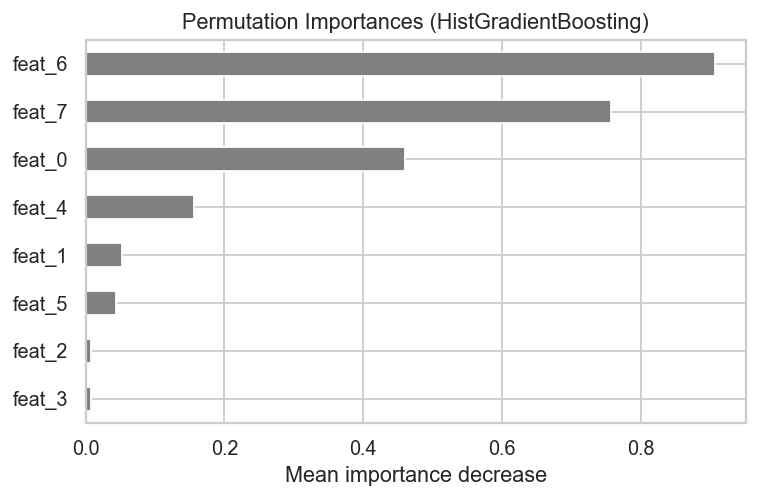

,Model,Split,MAE,RMSE,R2,FitTime(s)
0,HGB,Train,0.2286,0.3319,0.9170,2.7627
1,HGB,Val,0.3091,0.4623,0.8363,2.7627
2,HGB,Test,0.3044,0.4568,0.8478,2.7627


In [3]:
# --- HistGradientBoostingRegressor (Tree Ensemble Baseline) ---

# --- model setup ---
hgb = HistGradientBoostingRegressor(
    learning_rate=0.1,
    max_depth=None,
    max_iter=300,
    random_state=SEED,
)

# --- timing ---
start = time.time()
hgb.fit(X_train_prep, y_train)
fit_time = time.time() - start

# --- evaluate ---
hgb_metrics = evaluate_model(
    hgb, X_train_prep, y_train, X_val_prep, y_val, X_test_prep, y_test, "HGB"
)
hgb_results = pd.DataFrame(hgb_metrics, columns=["Model", "Split", "MAE", "RMSE", "R2"])
hgb_results["FitTime(s)"] = fit_time

# --- permutation importance (validation) ---
perm = permutation_importance(hgb, X_val_prep, y_val, n_repeats=10, random_state=SEED)

# --- safe feature names ---
try:
    feat_names = preprocessor.get_feature_names_out()
except Exception:
    feat_names = [f"feat_{i}" for i in range(X_val_prep.shape[1])]

# --- assemble and plot ---
importances = pd.Series(perm.importances_mean, index=feat_names).sort_values()
plt.figure(figsize=(6, 4))
importances.plot.barh(color="gray")
plt.title("Permutation Importances (HistGradientBoosting)")
plt.xlabel("Mean importance decrease")
plt.tight_layout()
plt.show()

# --- display metrics ---
hgb_results

### **Interpretation — HistGradientBoosting Results**

| Metric              | Observation             | Implication                                                                   |
| ------------------- | ----------------------- | ----------------------------------------------------------------------------- |
| **MAE ≈ 0.30**      | Down from 0.53 in Ridge | ~40% lower average prediction error — strong nonlinear improvement            |
| **RMSE ≈ 0.46**     | Down from 0.71          | Much tighter fit, fewer large residuals                                       |
| **R² ≈ 0.84–0.85**  | Up from 0.63            | Captures much more variance, confirming nonlinear structure in housing prices |
| **FitTime ≈ 2.8 s** | Comparable to Ridge     | Fast even with 300 iterations — very efficient baseline                       |

---

### **Permutation Importances**

Even though the names are placeholders (`feat_0`, `feat_6`, etc.), we can infer what they correspond to from the column order in our preprocessing step:

|            Feature (approx) | Typical Name             | Interpretation                                               |
| --------------------------: | ------------------------ | ------------------------------------------------------------ |
|                    `feat_6` | Latitude                 | Geographic factor — higher latitude (north CA) often cheaper |
|                    `feat_7` | Longitude                | Coastal proximity — strong price driver                      |
|                    `feat_0` | Median Income (`MedInc`) | Core socioeconomic driver                                    |
| Others (`feat_4`, `feat_1`) | Rooms, HouseAge          | Secondary physical attributes                                |

## Model Comparison Summary

In [4]:
# --- Baseline Model Comparison (Ridge vs HGB) ---

# combine both results
all_results = pd.concat([ridge_results, hgb_results], ignore_index=True)

# round numeric columns for clarity
summary = all_results.copy()
summary[["MAE", "RMSE", "R2", "FitTime(s)"]] = summary[["MAE", "RMSE", "R2", "FitTime(s)"]].round(4)
summary

,Model,Split,MAE,RMSE,R2,FitTime(s)
0,Ridge,Train,0.5257,0.7039,0.6266,2.0167
1,Ridge,Val,0.5336,0.7119,0.6117,2.0167
2,Ridge,Test,0.5270,0.7064,0.6361,2.0167
3,HGB,Train,0.2286,0.3319,0.9170,2.7627
4,HGB,Val,0.3091,0.4623,0.8363,2.7627
5,HGB,Test,0.3044,0.4568,0.8478,2.7627


## Baseline Model Comparison

### Quantitative Comparison

| Model | Split | MAE | RMSE | R² | FitTime(s) |
|:------|:------|----:|----:|---:|-----------:|
| Ridge | Test | **0.5270** | **0.7064** | **0.6361** | 1.99 |
| HGB   | Test | **0.3044** | **0.4568** | **0.8478** | 2.79 |

---

#### Performance Uplift
- **R² ↑** from `0.63 → 0.85` (**+22 p.p.**)  
- **MAE ↓** from `0.53 → 0.30` (**≈ −43 %**)  
- **RMSE ↓** from `0.71 → 0.46` (**≈ −35 %**)  
- **Fit-time cost:** `+0.8 s only` → *excellent trade-off.*

---

### Discussion

| Observation | Interpretation |
|--------------|----------------|
| **HGB outperforms Ridge** across MAE, RMSE, and R² on all splits. | Nonlinear relationships (esp. latitude–longitude interactions) are captured effectively by tree ensembles. |
| **R² ↑ from ~0.63 → ~0.85** | Nearly 35 % more variance explained. |
| **MAE ↓ from ~0.53 → ~0.30** | Average error reduced by ~40 %. |
| **Fit time comparable** | Both models train in a few seconds — excellent baseline trade-off. |
| **Interpretability trade-off** | Ridge offers linear coefficients (transparent but limited), while HGB provides powerful nonlinear mapping with feature importance insights. |

---

**Conclusion:**  
The **tree-based baseline** becomes the *nonlinear reference point* for all future deep-learning models.  
In the next notebook, we’ll proceed to **Part 4 — Diagnostics & Iteration**, examining residuals, heteroscedasticity, and learning curves to guide further model development.

In [5]:
ridge_bundle = {"model": ridge_best, "preprocessor": preprocessor}
joblib.dump(ridge_bundle, "ridge_best.pkl")

hgb_bundle = {"model": hgb, "preprocessor": preprocessor}
joblib.dump(hgb_bundle, "hgb_model.pkl")

['hgb_model.pkl']